## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py

## Download speech data

In [6]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [7]:
from constants import categories, inv_categories
import pandas as pd


def process_dataframe(data):
    df = pd.DataFrame(data)
    df['category'] = df.apply(
        lambda row: inv_categories[row['labels']], axis=1
        )
    df = df.loc[df['category'] != '_background_noise_', :]
    
    return df

trainDF = process_dataframe(dataDict['train'])
valDF = process_dataframe(dataDict['val'])
testDF = process_dataframe(dataDict['test']) 

print("Train DataFrame: {}".format(trainDF.shape[0]))
print("Validation DataFrame: {}".format(valDF.shape[0]))
print("Test DataFrame: {}".format(testDF.shape[0]))

Train DataFrame: 51088
Validation DataFrame: 6798
Test DataFrame: 6835


In [8]:
trainDF.head()

,files,labels,category
0,speechData/train/nine/9f4098cb_nohash_0.wav,1,nine
1,speechData/train/four/e7117d00_nohash_1.wav,3,four
2,speechData/train/nine/f92e49f3_nohash_2.wav,1,nine
3,speechData/train/no/e7ea8b76_nohash_4.wav,9,no
4,speechData/train/eight/72320401_nohash_1.wav,5,eight


## Tensorflow 2.0

In [0]:
!pip install -q tensorflow==2.0.0-beta1 

In [10]:
import tensorflow as tf

print(tf.__version__)

2.0.0-beta1


## Input pipeline

In [0]:
!pip install -q python_speech_features

In [0]:
from python_speech_features import logfbank
from scipy.io import wavfile
import numpy as np

sr = 16000

# load Wavs
def _loadWavs(filename):
    # Returns np array
    _, wave = wavfile.read(filename)
    
    # pad 
    if len(wave) < sr:
        silence_part = np.random.normal(0, 5, sr-len(wave))
        wave = np.append(np.asarray(wave), silence_part)
    
    return wave.astype(np.float32)

# Compute log Mel-filterbank
def _logMelFilterbank(wave):
    # shape = (99,40) 
    fbank = logfbank(wave, samplerate=16000, winlen=0.025, winstep=0.01, highfreq=sr/2, nfilt=40)
    return fbank.astype(np.float32)
    
def _parse_fn(filename, label):
    wave = _loadWavs(filename.numpy())
    fbank = _logMelFilterbank(wave)
    return fbank, np.asarray(label).astype(np.int32)

In [0]:
import os

BATCH_SIZE = 32
NUM_DATA = 10000

train_data = tf.data.Dataset.from_tensor_slices(
    (trainDF['files'].tolist()[:NUM_DATA],
     trainDF['labels'].tolist()[:NUM_DATA])
)
val_data = tf.data.Dataset.from_tensor_slices(
    (valDF['files'].tolist()[:NUM_DATA],
     valDF['labels'].tolist()[:NUM_DATA])
)

train_data = (train_data.map(
                lambda filename, label: tuple(tf.py_function(
                                                 _parse_fn, inp = [filename, label], Tout = [tf.float32, tf.int32])), 
                         num_parallel_calls=os.cpu_count())
            .cache('train_data_cache')
            .shuffle(buffer_size=1000)
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=1)
           )  

val_data = (val_data.map(
                lambda filename, label: tuple(tf.py_function(
                                                 _parse_fn, inp = [filename, label], Tout = [tf.float32, tf.int32])), 
                         num_parallel_calls=os.cpu_count())
            .cache('val_data_cache')
            .shuffle(buffer_size=1000)
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=1)
           )  

## Model

In [14]:
model = tf.keras.models.Sequential()

# Normalization layer
model.add(tf.keras.layers.Reshape(target_shape=(99,40,1), input_shape=(99,40)))
model.add(tf.keras.layers.BatchNormalization())

###########################
# Conv 1a
model.add(tf.keras.layers.Conv2D(16,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Conv 1b
model.add(tf.keras.layers.Conv2D(16,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Pooling 1
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

###########################
# Conv 2a
model.add(tf.keras.layers.Conv2D(32,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Conv 2b
model.add(tf.keras.layers.Conv2D(32,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Pooling 2
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

###########################
# Conv 3a
model.add(tf.keras.layers.Conv2D(64,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Conv 3b
model.add(tf.keras.layers.Conv2D(64,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Pooling 3
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

###########################
# Conv 4a
model.add(tf.keras.layers.Conv2D(128,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Conv 4b
model.add(tf.keras.layers.Conv2D(128,
                                kernel_size = (3,3),
                                padding = 'same'
                                ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Pooling 4
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))


# Classification
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512)) 
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
### linear
model.add(tf.keras.layers.Dense(256,activation = 'relu')) 
## softmax
model.add(tf.keras.layers.Dense(30, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),#optimizers.SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True), 
              metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 99, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 40, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 40, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 40, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 99, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 40, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 99, 40, 16)        6

In [15]:
steps_per_epoch = NUM_DATA // BATCH_SIZE
steps_per_epoch_val = valDF['files'].shape[0] // BATCH_SIZE
EPOCHS = 10

history = model.fit(train_data.repeat(),
          steps_per_epoch=steps_per_epoch,
          validation_data=val_data.repeat(),
          validation_steps=steps_per_epoch_val,
          epochs=EPOCHS)



W0627 14:09:40.537656 140011726194432 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0627 14:09:40.538624 140011717801728 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0627 14:09:40.540655 140011717801728 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0627 14:09:40.539645 140011726194432 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0627 14:09:40.558607 140011717801728 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


Epoch 1/10


W0627 14:09:44.859032 140012753094528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


312/312 [==============================] - 262s 839ms/step - loss: 2.2366 - sparse_categorical_accuracy: 0.3544 - val_loss: 2.1895 - val_sparse_categorical_accuracy: 0.3694
Epoch 2/10
312/312 [==============================] - 176s 566ms/step - loss: 0.8727 - sparse_categorical_accuracy: 0.7333 - val_loss: 1.2401 - val_sparse_categorical_accuracy: 0.6582
Epoch 3/10
312/312 [==============================] - 176s 565ms/step - loss: 0.5491 - sparse_categorical_accuracy: 0.8316 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.7842
Epoch 4/10
312/312 [==============================] - 176s 563ms/step - loss: 0.4274 - sparse_categorical_accuracy: 0.8688 - val_loss: 0.3915 - val_sparse_categorical_accuracy: 0.8848
Epoch 5/10
312/312 [==============================] - 176s 563ms/step - loss: 0.3284 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.3602 - val_sparse_categorical_accuracy: 0.8916
Epoch 6/10
312/312 [==============================] - 176s 564ms/step - loss: 0.2713 - spar

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [31]:
## Save model 
model_json = model.to_json()
with open("/content/gdrive/My Drive/speechRecognition/firstModel/model.json", "w") as file:
    file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/speechRecognition/firstModel/model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [40]:
import pickle
## Save history data
with open('/content/gdrive/My Drive/speechRecognition/firstModel/train_results.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


In [0]:
## test load
with open('/content/gdrive/My Drive/speechRecognition/firstModel/train_results.pickle', 'rb') as handle:
    hist = pickle.load(handle)

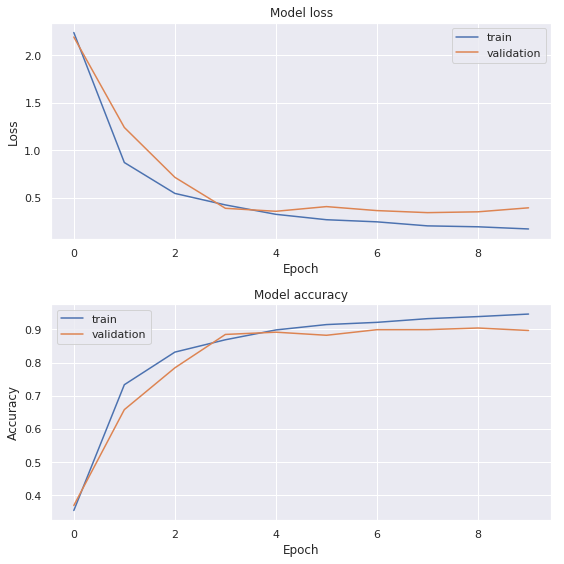

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

acc = hist['sparse_categorical_accuracy']
val_acc = hist['val_sparse_categorical_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

### Predict



In [0]:
def _parse_fn_test(filename):
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave)
    return fbank

x_test = np.zeros((len(testDF['files']), 99, 40))

for i in range(len(x_test)):
    x_test[i] = _parse_fn_test(testDF['files'][i])

In [106]:
out = model.predict(x_test,verbose=1, workers=os.cpu_count(), use_multiprocessing=True)

6835/6835 [==============================] - 24s 3ms/sample


In [0]:
y_pred = np.argmax(out,axis=1)
y_true = testDF['labels'].tolist()

In [112]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
cm = confusion_matrix(y_pred, y_true)

Accuracy: 0.8903


Normalized confusion matrix


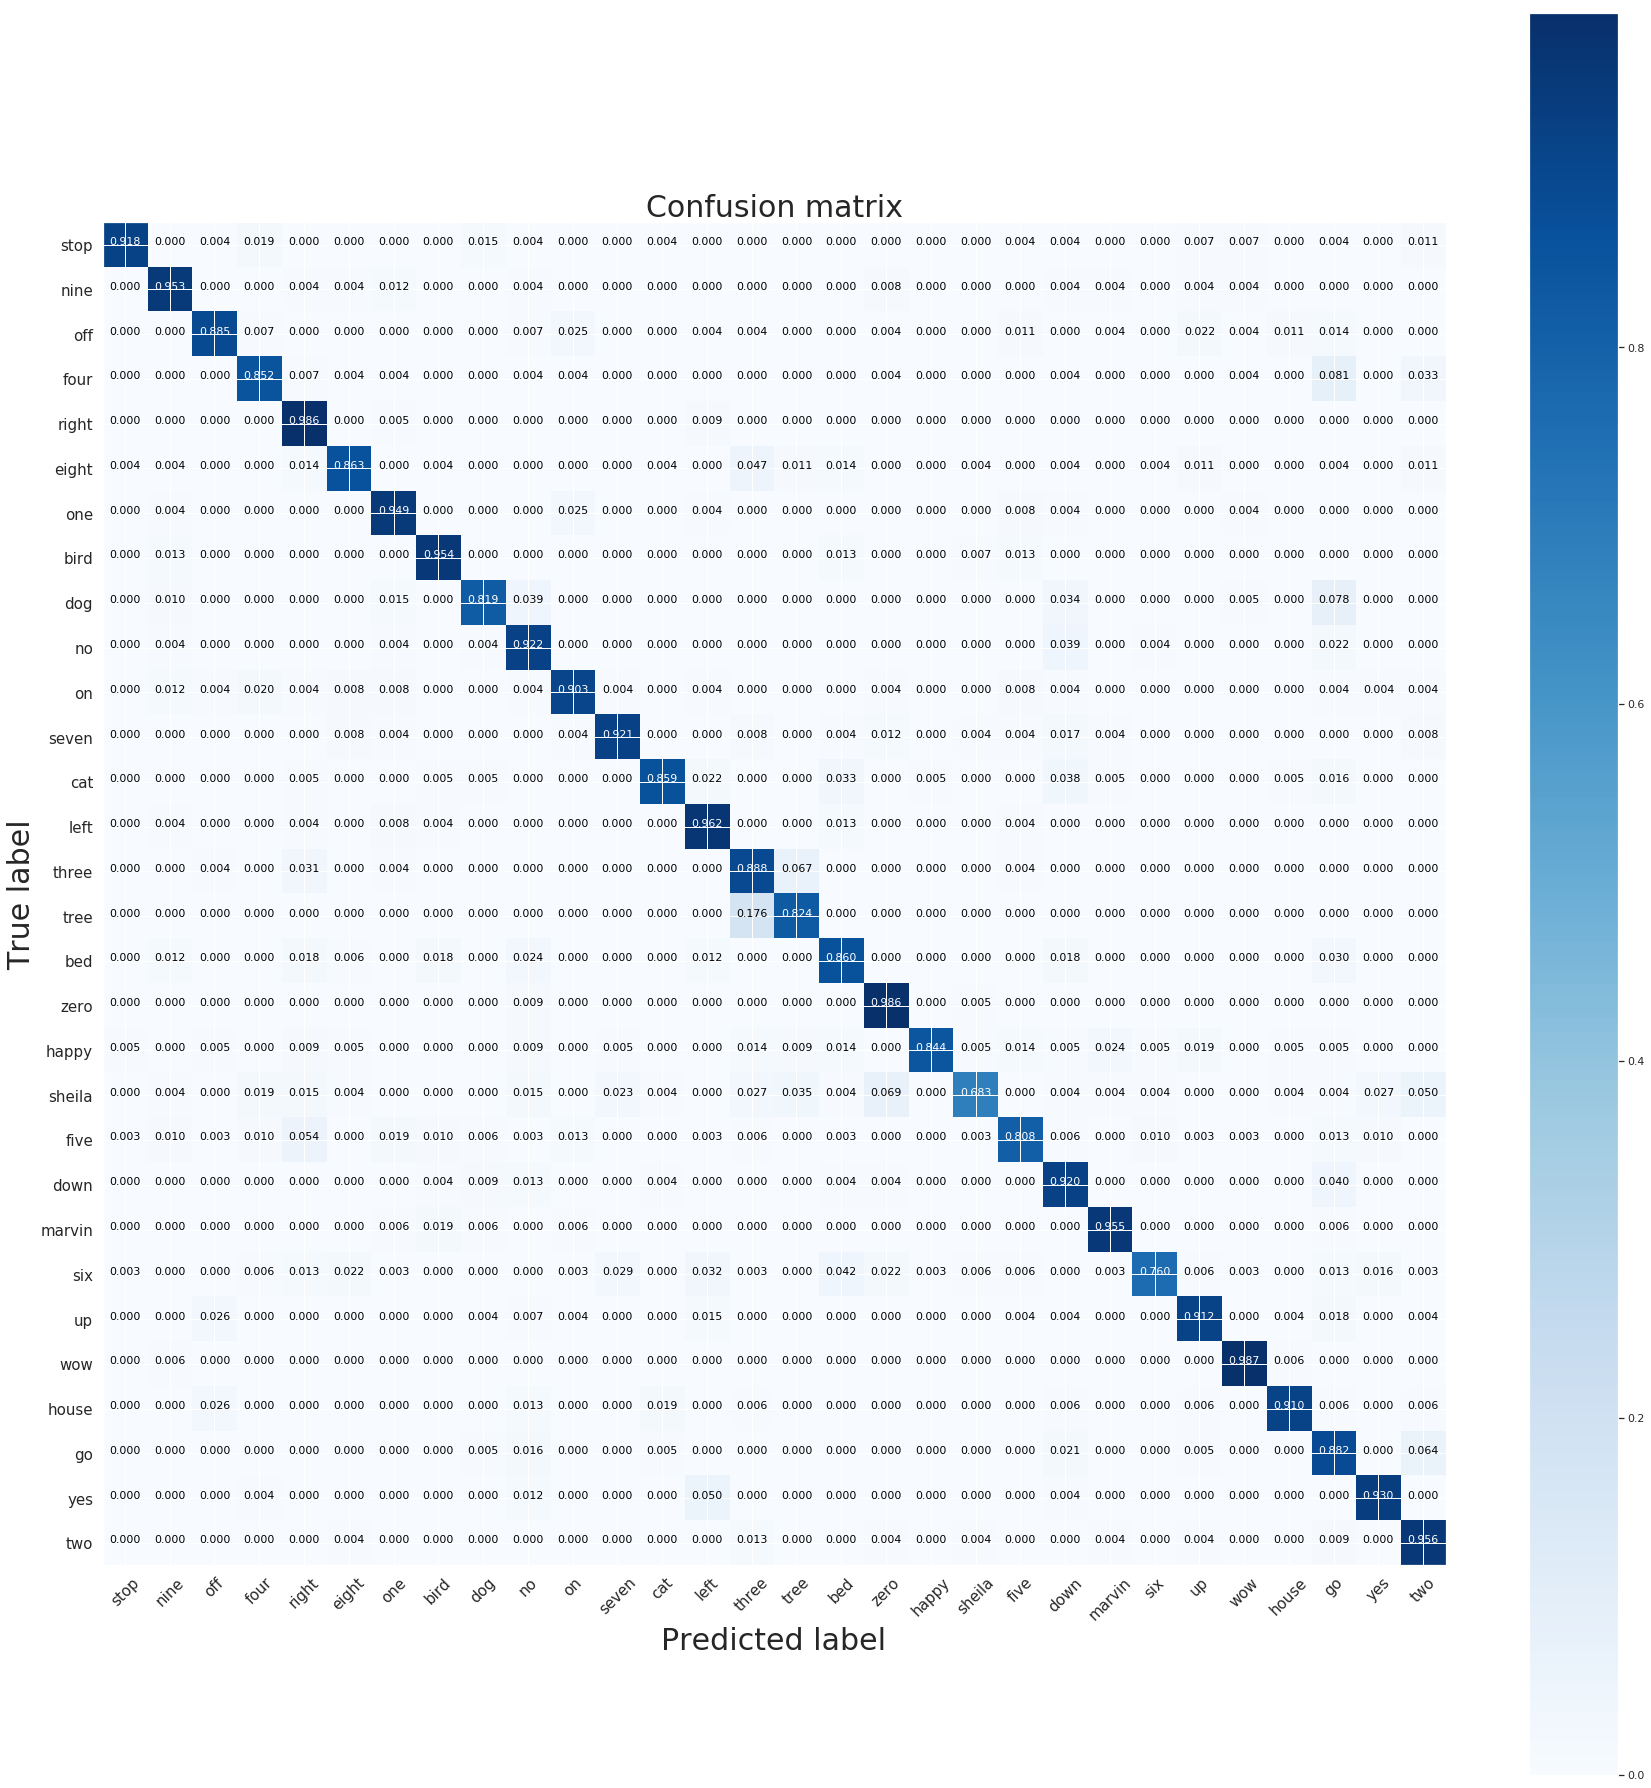

In [113]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.tight_layout()
    
plot_confusion_matrix(cm, classes=list(inv_categories.values())[:-1], normalize=True)